# Plot snapshots of the dynamic rupture simulation

2024.6.19 Kurama Okubo

- 2024.09.04 update for new event set
- 2024.09.10 ~~update to add the critical nucleation radius scaling on the second axes~~ It was visually too complicated. Instead of that, we added the length scale in the figures.
- 2024.12.21 update for the new merged catalog.
- 2025.1.30 Clean up the notebook for the master plot.

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib as mpl

%matplotlib inline
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time

from importParaviewColormap import importParaviewColormap
import seaborn as sns
from matplotlib.collections import LineCollection

%load_ext autoreload
%autoreload 2


plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75

In [2]:
figdir = "../figure/03_snapshot"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [3]:
E = 96e9
nu = 0.246 # metagabbro
mu = E/(2*(1+nu))

a_patch = 4.0e-3
a_nuc = 2.5e-3 # nucleation radius 

nb_x_elements = 1024 #128 #1024
nb_z_elements = 1024 #128 #1024


Ifmasteroutput=True # add file key to the master output
if Ifmasteroutput:
    filekey = "_master"
else:
    filekey = ""

In [4]:
# case study parameter casename

a_patch = 4.0e-3
a_nuc = 2.5e-3
a_margin = 4.08e-3

rupturetype = "pulse"
pdcscaling = 0.60 #0.65
bgbeta= 0.35 #0.4

sig_n = 6e6

IfBinaryOutput = True

casestr = f"a={a_patch*1e3:.2f}_ruptype={rupturetype}_pdcscaling={pdcscaling:.3f}_sn={sig_n/1e6:.1f}MPa_hatfr=0.3_bgbeta={bgbeta:.2f}"

finame=f"../../preprocess_modelsetup/data/gouge_dynamicrupture_modelparam_{casestr}{filekey}.csv"

# Read model parameters
df_modelparam = pd.read_csv(finame, index_col=0)


datadir_root = "/Volumes/Okuboetal2025_masterHDD/RuptureSimulation/main_casestudy/build_hpcv62_mastercase_v3/simulations_main_casestudy_hpc_master"

casestr

'a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35'

In [5]:
df_modelparam.head()

,M0_mean,Tw_mean,Mw_mean,hat_sn_patch,hat_sn_background,delsig_withmargin_try,slip_try,initialstress_fraction,delsigma_factor,fp_patch,...,GIIC_patch,GIIC_background,Sratio_nuc,Sratio_patch,Ainit_nuc,Ainit_patch,Anuc_nuc,Anuc_patch,rnuc_nuc,rnuc_patch
gougeevent_id,,,,,,,,,,,,,,,,,,,,,
4,0.592607,0.000003,-6.221489,6000000.0,2000000.0,3817368.370,2.941529e-07,0.925,0.6,0.737013,...,0.063389,0.0,0,0.144801,3.82,3.827670,0.000002,0.000002,0.783304,0.784090
9,0.046991,0.000002,-6.955323,6000000.0,2000000.0,302700.368,2.332502e-08,0.925,0.6,0.357049,...,0.001808,0.0,0,0.884659,3.82,5.060161,0.000005,0.000007,1.311379,1.509311
18,0.755830,0.000003,-6.151051,6000000.0,2000000.0,4868794.570,3.751721e-07,0.925,0.6,0.850680,...,0.092430,0.0,0,0.131041,3.82,3.825794,0.000002,0.000002,0.719315,0.719860
19,0.055755,0.000002,-6.905809,6000000.0,2000000.0,359156.898,2.767536e-08,0.925,0.6,0.363152,...,0.002218,0.0,0,0.758343,3.82,4.624378,0.000005,0.000007,1.312650,1.444255
20,0.865466,0.000003,-6.111833,6000000.0,2000000.0,5575033.400,4.295923e-07,0.925,0.6,0.927031,...,0.114155,0.0,0,0.124712,3.82,3.825041,0.000001,0.000001,0.685213,0.685665


In [6]:
# Select gouge event id to plot the snapshots
expr_id = 87
gougeevent_id = 129 # 24, 50, 52, 72, 129

In [7]:
df_modelparam_selected = df_modelparam[df_modelparam.index == gougeevent_id]

# if ifParamStudy:
simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}_{df_modelparam_selected.delsigma_factor.values[0]:.4f}"
# else:
    # simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}"
        
# simulation_name = f"{expr_id}__{df_modelparam_selected.index[0]:04d}_{casestr}"

print(f"Process {gougeevent_id}: {simulation_name}")


Process 129: fb03-087__0129_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4100


In [8]:
figdir_snapshot_master = f"{figdir}/{simulation_name}"
if not os.path.exists(figdir_snapshot_master):
    os.makedirs(figdir_snapshot_master)

# Plot snapshots of the dynamic rupture simulation

## Set the model parameters

In [9]:
df_time = pd.read_csv(os.path.join(datadir_root,simulation_name+".time"), header=None, sep=' ', index_col=0)
df_coord = pd.read_csv(os.path.join(datadir_root,simulation_name+".coords"), header=None, sep=' ', index_col=None)
NT=len(df_time)


In [10]:
# location of the center of nucleation zone
nuc_x = -(a_patch - a_nuc)
nuc_z = 0

xcoord = df_coord.loc[:,0].values
zcoord = df_coord.loc[:,2].values

x_length = xcoord.max()
z_length = zcoord.max()

# ref also: https://stackoverflow.com/a/35176314
dgrid = (zcoord[1] - zcoord[0])
print(f"Grid size: {dgrid*1e3}[mm]") 

X = xcoord.reshape(nb_x_elements,nb_z_elements).T- dgrid/2 - x_length/2
Z = zcoord.reshape(nb_x_elements,nb_z_elements).T- dgrid/2 - z_length/2



Grid size: 0.0390625[mm]


In [11]:
# np.unique(xcoord)[512:514]

## Read data

In [12]:
read_comp = 0 #0: Mode II direction, 1: normal (Mode I), 2:Mode III direction 

# read velocity
read_parameter = f"top_velo_{read_comp}" # select the parameter to read
if IfBinaryOutput:
    D = np.fromfile(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), dtype="float32")
    df_data_vel = pd.DataFrame(data=D.reshape((NT, -1)))
else:
    df_data_vel = pd.read_csv(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), header=None, sep=' ', engine="c")
    
# read displacement
read_parameter = f"top_disp_{read_comp}" # select the parameter to read
if IfBinaryOutput:
    D = np.fromfile(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), dtype="float32")
    df_data_disp = pd.DataFrame(data=D.reshape((NT, -1)))
else:
    df_data_disp = pd.read_csv(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), header=None, sep=' ', engine="c")

# read cohesion (shear traction)
read_parameter = f"cohesion_{read_comp}" # select the parameter to read
if IfBinaryOutput:
    D = np.fromfile(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), dtype="float32")
    df_data_coh = pd.DataFrame(data=D.reshape((NT, -1)))
else:
    df_data_coh = pd.read_csv(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), header=None, sep=' ', engine="c")


# check if the grid size is consistent to the data shape
assert len(df_data_vel.columns) == len(xcoord)
assert len(df_data_disp.columns) == len(xcoord)
assert len(df_data_coh.columns) == len(xcoord)


# Add critical nucleation radius as the length scale

We add the critical nucleation radius as the length scale of the ruptures. Note that the process zone size is not used here because it is defined on the 2D fault.



In [13]:
rnuc_patch_event = df_modelparam_selected["rnuc_patch"].values[0]# [mm]
rnuc_patch_event

0.897392765

In [14]:
#---double axes for length scale---#
# not used
def m2nondim(x, Rc):
    # Rc: critical nucleation radius
    return x/Rc
    
def nondim2m(x_nondim, Rc):
    return x_nondim*Rc

## Plot snapshots

In the previous process, we dump the timings of snapshots. First column is the times plotted in the STF, and second column is the time associated with the dynamic rupture simulation, respectively.

In [15]:
# t_plot_list = np.array([0.4, 0.8, 1.8, 2.0, 2.2]) * 1e-6
t_plot_list = np.array([0.8, 1.6, 1.8, 2.0, 4.0]) * 1e-6 # tentative snaps

# dump the list
# ref: https://stackoverflow.com/a/28783925
with open(f"../data/t_plot_list_{casestr}{filekey}.txt", "w") as fo:
    fo.write(','.join(str(i) for i in t_plot_list))

In [16]:
fi_tplot_STFsnapshot = f"../data/tshift_STFplot_{gougeevent_id}_{casestr}.txt"

if os.path.exists(fi_tplot_STFsnapshot):
    # To synchronize the time with the STF plot, we load the time shift used to plot the STF plot
    snapshot_t_STFplot = []
    snapshot_t_dynrup = []
    with open(f"../data/tshift_STFplot_{gougeevent_id}_{casestr}.txt") as fi:
        for line in fi:
            t_STF, t_dynrup = [float(x) for x in line.split(",")]
            print(t_STF, t_dynrup)
            snapshot_t_STFplot.append(t_STF*1e-6)
            snapshot_t_dynrup.append(t_dynrup*1e-6)

else:
    # use tentative list
    snapshot_t_STFplot = t_plot_list
    snapshot_t_dynrup = t_plot_list


In [17]:
snapshot_t_STFplot, snapshot_t_dynrup

(array([8.0e-07, 1.6e-06, 1.8e-06, 2.0e-06, 4.0e-06]),
 array([8.0e-07, 1.6e-06, 1.8e-06, 2.0e-06, 4.0e-06]))

In [18]:
rightmargin = 0.005
colorbargridwidth = 0.02
width_ratios = np.hstack([np.ones(len(snapshot_t_dynrup))*(1-(rightmargin+colorbargridwidth))/len(snapshot_t_dynrup), rightmargin, colorbargridwidth])


In [19]:
2*df_data_vel.max().max(), 2*df_data_vel.min().min(), 2*df_data_disp.max().max()*1e6, df_data_coh.max().max()/1e6

(1.534537672996521, -0.004333456512540579, 0.39604211110599863, 5.279377)

In [20]:
df_time

,1
0,
0,0.000000e+00
3,9.777979e-09
6,1.955596e-08
9,2.933394e-08
12,3.911191e-08
...,...
1827,5.954789e-06
1830,5.964567e-06
1833,5.974345e-06


In [21]:
snapshot_t_dynrup

array([8.0e-07, 1.6e-06, 1.8e-06, 2.0e-06, 4.0e-06])

In [22]:
# compute max slip value to plot the ruptured area
t_plot_et_ind = np.where(df_time>=snapshot_t_dynrup[-1])[0][0]
data_disp_et = df_data_disp.loc[t_plot_et_ind, :].values
max_slip = np.max(data_disp_et)  * 2 # from max displacement to slip
print(f"maximum slip is {max_slip*1e6:.6f}μm")

# Save the max slip for the case with self-healing

if rupturetype=="pulse":
    with open(f"../data/maxslip_{casestr}.txt", "w") as fo:
        fo.write(f"{max_slip:12.8e}")

# read the file
casestr_maxslip = f"a={a_patch*1e3:.2f}_ruptype={'pulse'}_pdcscaling={pdcscaling:.3f}_sn=8.0MPa_hatfr=0.3_bgbeta={bgbeta:.2f}"

if rupturetype=="crack" and os.path.exists(f"../data/maxslip_{casestr_maxslip}.txt"):
    with open(f"../data/maxslip_{casestr_maxslip}.txt", "r") as fi:
        max_slip = float(fi.readline())
        print(f"maxslip is read from pulse result: {max_slip*1e6:e} μm")

maximum slip is 0.396042μm


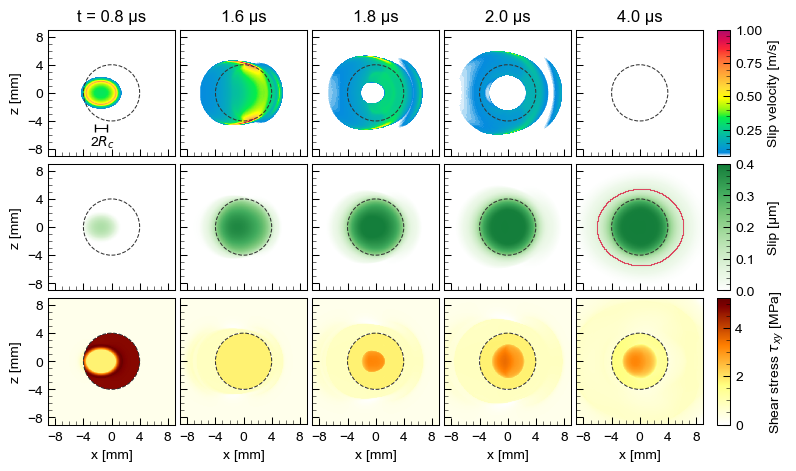

In [23]:
fig, axs = plt.subplots(3, len(snapshot_t_STFplot)+2, figsize=(8.8, 5.13), gridspec_kw={'width_ratios': width_ratios})
fig.subplots_adjust(wspace=0.06, hspace=0.06)

vmax_vel = 1.0 #0.06 #1.2 #1.5
vmin_vel = 0.05 #0.0 # 0.05

if rupturetype=="crack":
    vmax_disp = 0.54 # increase vmax_disp to show the slip distribution
else:
    vmax_disp = 0.4 #0.3
    
vmin_disp = 0.0
vmax_coh = 5.23 # max tau
vmin_coh = 0

xylimit = [-9, 9] # [-10, 10]

value_factor_double = 2.0 # double the value for slip and slip velocity

alpha_thresh = 0.2 #0.3 # threshold of slip contour

# loop the plotting snaps
t_plot_true_all = []

cmap_vel = importParaviewColormap("pararainbow_uni_w"+".json", False) # colormap made with Paraview
cmap_disp = importParaviewColormap("paraGreen2_w"+".json", False)
# cmap_disp = importParaviewColormap("pararainbow"+".json", False)
# cmap_disp = plt.get_cmap('viridis')
# cmap_coh = importParaviewColormap("parainferno_w"+".json", False)

# ref: https://stackoverflow.com/a/18926541
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap_coh = plt.get_cmap('afmhot_r')
# cmap_coh = plt.get_cmap('gist_heat_r')
cmap_coh = truncate_colormap(cmap_coh, 0.0, 0.8)


for i, t_plot_target in enumerate(snapshot_t_dynrup):
    t_plot_ind = np.where(df_time>=t_plot_target)[0][0]
    t_plot_true = df_time.iloc[t_plot_ind].values[0]
    assert np.abs(t_plot_target-t_plot_true) < 1e-7 # check the difference of the requested and plotted time on the snapshot
    t_plot_true_all.append(t_plot_true)
    
    data_vel = df_data_vel.loc[t_plot_ind, :].values
    data_disp = df_data_disp.loc[t_plot_ind, :].values
    data_coh = df_data_coh.loc[t_plot_ind, :].values
    
    V_vel = data_vel.reshape(nb_x_elements,nb_z_elements).T
    V_disp= data_disp.reshape(nb_x_elements,nb_z_elements).T
    V_coh = data_coh.reshape(nb_x_elements,nb_z_elements).T
    
    # replace 0 to small number for the logplot
    # V_vel[V_vel<=0] = 1e-12
    
    h1 = axs[0, i].pcolormesh(X*1e3, Z*1e3, value_factor_double*V_vel, norm=colors.Normalize(vmin=vmin_vel, vmax=vmax_vel), cmap=cmap_vel, rasterized=True) # multiply 2 for slip velocity
    h2 = axs[1, i].pcolormesh(X*1e3, Z*1e3, value_factor_double*V_disp*1e6, norm=colors.Normalize(vmin=vmin_disp, vmax=vmax_disp), cmap=cmap_disp, rasterized=True) # multiply 2 for slip velocity
#     h2 = axs[1, i].pcolormesh(X*1e3, Z*1e3, value_factor_double*np.log10(V_disp)*1e6, cmap='viridis', rasterized=True) # multiply 2 for slip velocity
    h3 = axs[2, i].pcolormesh(X*1e3, Z*1e3, V_coh/1e6, norm=colors.Normalize(vmin=vmin_coh, vmax=vmax_coh), cmap=cmap_coh, rasterized=True)

    
    #---Plot contour of the ruptured region for the slip plot---#
    #--- Evaluate ruptured area ---#
    u_thresh = alpha_thresh * max_slip
     # ref: https://stackoverflow.com/a/63459354
    value = u_thresh

    v = np.diff(value_factor_double*V_disp > value, axis=1)
    h = np.diff(value_factor_double*V_disp > value, axis=0)

    l = np.argwhere(v.T)
    vlines = np.array(list(zip(np.stack((X[0][l[:, 0] + 1]*1e3, Z[:, 0][l[:, 1]]*1e3)).T,
                               np.stack((X[0][l[:, 0] + 1]*1e3, Z[:, 0][l[:, 1] + 1]*1e3)).T)))
    l = np.argwhere(h.T)
    hlines = np.array(list(zip(np.stack((X[0][l[:, 0]]*1e3, Z[:, 0][l[:, 1] + 1]*1e3)).T,
                               np.stack((X[0][l[:, 0] + 1]*1e3, Z[:, 0][l[:, 1] + 1]*1e3)).T)))

    lines = np.vstack((vlines-dgrid/2*1e3, hlines-dgrid/2*1e3))
    contour_disp_lc = "crimson"
    if t_plot_target == snapshot_t_dynrup[-1]:
        axs[1, i].add_collection(LineCollection(lines, lw=0.75, colors=contour_disp_lc))

    
for ii in range(3):
    for jj in range(len(snapshot_t_dynrup)):

        if ii==2:
            axs[ii, jj].set_xlabel("x [mm]")
            axs[ii, jj].tick_params(axis='x', pad=5)
        else:
            axs[ii, jj].tick_params(axis='x', labelbottom=False)


        if jj==0:
            axs[ii, jj].set_ylabel("z [mm]")
        else:
            axs[ii, jj].tick_params(axis='y', labelleft=False)
        
        axs[ii, jj].set_aspect('equal', adjustable="box")
        axs[ii, jj].set_xlim(xylimit)
        axs[ii, jj].set_ylim(xylimit)

        axs[ii, jj].set_xticks(np.linspace(-8, 8, 5))
        axs[ii, jj].set_yticks(np.linspace(-8, 8, 5))
        
        if ii==1:
            # raw of slip            
            # axs[ii, jj].tick_params(axis='x', which="both", colors='w')
            # axs[ii, jj].tick_params(axis='y', which="both", colors='w')
            patch_lc = [0.2, 0.2, 0.2] #"w"
        else:
            patch_lc = [0.2, 0.2, 0.2]
            
        
        line_patch = plt.Circle((0, 0), a_patch*1e3, fill=False, ls="--", lw=0.75, ec=patch_lc)
        line_nuc = plt.Circle((nuc_x*1e3, nuc_z), a_nuc*1e3, ec=[0.2, 0.2, 0.2], fill=False, ls=":", lw=0.75)
#         line_margin = plt.Circle((0, 0), R_margin*1e3, ec='w', fill=False, ls="--")

        axs[ii, jj].add_patch(line_patch)
#         axs[ii, jj].add_patch(line_nuc)
#         axs[ii, jj].add_patch(line_margin)

        #------------------#
        # add second  axes
        #------------------#
        # https://pythonmatplotlibtips.blogspot.com/2018/01/add-second-x-axis-below-first-x-axis-python-matplotlib-pyplot.html
        # newlabel = np.array([-5, 0, 5])
        # newpos  = np.array([nondim2m(x, rnuc_patch_event) for x in newlabel])  # position of the ticklabels in the old axis


        # if (ii==0) & (jj<=len(snapshot_t_dynrup)-1):
        #     ax2=axs[ii, jj].secondary_xaxis('top', functions=(lambda x: m2nondim(x, rnuc_patch_event*1e3),
        #                                                         lambda x: nondim2m(x, rnuc_patch_event*1e3))) 
        #     ax2.set_zorder(1)
        #     ax2.tick_params(axis='x', which='minor')
        #     ax2.set_xticks([-10, -5, 0, 5, 10])
        #     # axs[ii, jj].spines['top'].set_visible(False)

  
        # if (jj==len(snapshot_t_dynrup)-1):
        #     ax2=axs[ii, jj].secondary_yaxis('right', functions=(lambda x: m2nondim(x, rnuc_patch_event*1e3),
        #                                                         lambda x: nondim2m(x, rnuc_patch_event*1e3))) 
        #     ax2.set_zorder(1)
        #     ax2.tick_params(axis='y', which='minor')
        #     ax2.set_yticks([-10, -5, 0, 5, 10])

for kk, t_plot_true in enumerate(snapshot_t_STFplot):
    if kk==0:
        titlestr=f"t = {t_plot_true*1e6:.1f} μs"
    else:
        titlestr=f"{t_plot_true*1e6:.1f} μs"
        
    axs[0, kk].set_title(titlestr)

# Annotation
# 1. length-scale of Lc
# lengthscale_x = -1.5
lengthscale_y = -5.0
axs[0, 0].plot([nuc_x*1e3-rnuc_patch_event, nuc_x*1e3+rnuc_patch_event], [lengthscale_y, lengthscale_y], "-", marker="|", c="k", lw=0.75)
axs[0, 0].text(-3.0, -7.6, r"2$R_c$", c="k") 

# some texts
# axs[1, len(snapshot_t_dynrup)-1].annotate(f"{int(alpha_thresh*100):d}% of max. slip", xy=(0, -5.5), xytext=(-8., -8.), arrowprops={"arrowstyle": "-",},  ha='left')

# if rupturetype=="pulse":
#     axs[2, len(snapshot_t_dynrup)-3].annotate(f"Self-healing of friction", xy=(0, -1), xytext=(-8., -8.), arrowprops={"arrowstyle": "-",},  ha='left')

    
# remove axis in the margin grids
for ii in range(3):
    axs[ii, -2].set_axis_off()

# color bars
# vel
cticks = [0.001, 0.01, 0.1]
cticklabels= [str(x) for x in cticks]

cb_vel = fig.colorbar(h1, cax=axs[0, -1], orientation="vertical", shrink=1.0 )#ticks=cticks)
cb_vel.set_label("Slip velocity [m/s]")

# disp
cb_disp = fig.colorbar(h2, cax=axs[1, -1], orientation="vertical", shrink=1.0 )#ticks=cticks)
cb_disp.set_label("Slip [μm]")

# cohesion
cb_coh = fig.colorbar(h3, cax=axs[2, -1], orientation="vertical", shrink=1.0 )#ticks=cticks)
cb_coh.set_label("Shear stress $τ_{xy}$ [MPa]")

fig.align_ylabels(axs[:, -1])

# add figure labels
# fig_labels = ["a", "b", "c"]
# for ii in range(3):
#     axs[ii, 0].text(-16, 9, f"({fig_labels[ii]})", fontsize=14, fontweight="bold", zorder=4)

# fig.tight_layout() # this reset the figure margins


plt.savefig(figdir_snapshot_master + "/master_snapshot_{}_comp{}{}.png".format(simulation_name, read_comp, filekey), dpi=300, bbox_inches="tight")
plt.savefig(figdir_snapshot_master + "/master_snapshot_{}_comp{}{}.pdf".format(simulation_name, read_comp, filekey), bbox_inches="tight")
plt.savefig(figdir_snapshot_master + "/master_snapshot_{}_comp{}{}.eps".format(simulation_name, read_comp, filekey), bbox_inches="tight")

# plt.close()
# plt.clf()

## Evaluate the final rupture size

In [24]:
maxarea_x = lines[:, :, 0].max()
minarea_x = lines[:, :, 0].min()
maxarea_z = lines[:, :, 1].max()
minarea_z = lines[:, :, 1].min()

Text(0.5, 0.9, 'x fraction:1.543\nz fraction:1.362')

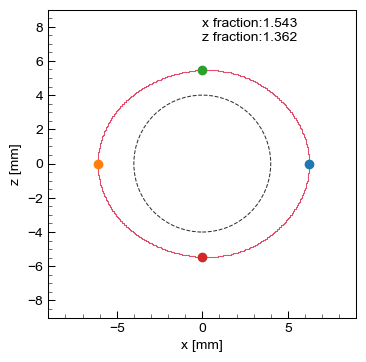

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.add_collection(LineCollection(lines, lw=0.75, colors=contour_disp_lc))

line_patch = plt.Circle((0, 0), a_patch*1e3, fill=False, ls="--", lw=0.75, ec=patch_lc)
# line_nuc = plt.Circle((nuc_x*1e3, nuc_z), a_nuc*1e3, ec=[0.2, 0.2, 0.2], fill=False, ls=":", lw=0.75)
# line_margin = plt.Circle((0, 0), R_margin*1e3, ec='w', fill=False, ls="--")

ax.add_patch(line_patch)


ax.plot(maxarea_x, 0, "o")
ax.plot(minarea_x, 0, "o")
ax.plot(0, maxarea_z, "o")
ax.plot(0, minarea_z, "o")

ax.set_xlabel("x [mm]")
ax.set_ylabel("z [mm]")
ax.set_aspect('equal', adjustable="box")
ax.set_xlim(xylimit)
ax.set_ylim(xylimit)

# compute the fraction in x and z
rupturearea_fraction_x = (maxarea_x-minarea_x)/(2*a_patch*1e3)
rupturearea_fraction_z = (maxarea_z-minarea_z)/(2*a_patch*1e3)
annottxt = f"x fraction:{rupturearea_fraction_x:.3f}\nz fraction:{rupturearea_fraction_z:.3f}"
ax.text(0.5, 0.9, annottxt, transform=ax.transAxes)
# fig.tight_layout()

In [26]:
a_patch

0.004

In [27]:
t_plot_true_all

[8.017942e-07, 1.603588e-06, 1.808926e-06, 2.004486e-06, 4.008971e-06]

In [28]:
snapshot_t_dynrup

array([8.0e-07, 1.6e-06, 1.8e-06, 2.0e-06, 4.0e-06])

In [29]:
t_plot_true_all

[8.017942e-07, 1.603588e-06, 1.808926e-06, 2.004486e-06, 4.008971e-06]

# Plot and save the traction history

We plot and save the shear traction history at a point.

In [30]:
traction_loc = [1.5e-3, 0.0e-3] # location to plot traction history


In [31]:
xzcoords = np.vstack([xcoord - dgrid/2 - x_length/2, zcoord - dgrid/2 - x_length/2])

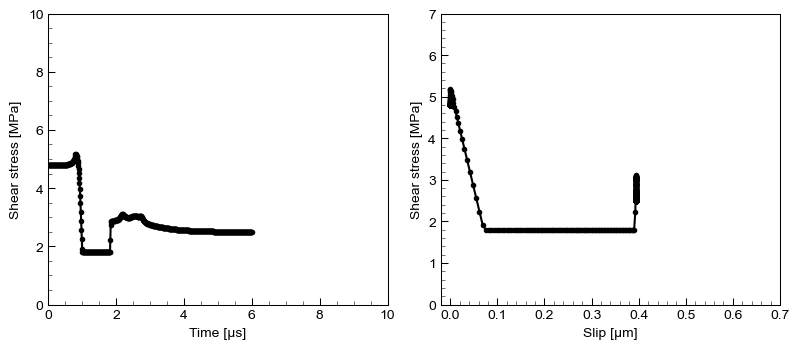

In [32]:
# for poster
fig, axs = plt.subplots(1, 2, figsize=(8, 3.6))

trac_x_ind = np.where(X[0, :] >= traction_loc[0])[0][0]
trac_z_ind = np.where(Z[:, 0] >= traction_loc[1])[0][0]

xzind = trac_x_ind * nb_x_elements + trac_z_ind

# debug
# xzind = trac_z_ind * nb_x_elements + trac_x_ind

assert np.linalg.norm(np.array(xzcoords[:, xzind]) - np.array(traction_loc)) < 1e-3

loc_traction = df_data_coh.loc[:, xzind]
loc_slip = df_data_disp.loc[:, xzind] * 2 # double to convert from displacement to slip

axs[0].plot(df_time.values[:, 0]*1e6, loc_traction/1e6, ".-", c="k")
axs[1].plot(loc_slip*1e6, loc_traction/1e6, ".-", c="k")

    
axs[0].set_xlim([0, 10])
axs[0].set_ylim([0, 10])
# ax.set_ylim([-0.02, 1.1])
axs[0].set_xlabel("Time [μs]")
axs[0].set_ylabel("Shear stress [MPa]")
# axs[0].legend(loc=4)

# axs[1].set_ylim([4, 10])

axs[1].set_xlim([-0.02, 0.7])
axs[1].set_ylim([0, 7])
axs[1].set_xlabel("Slip [μm]")
axs[1].set_ylabel("Shear stress [MPa]")
# axs[1].legend(loc=4)

# ax.legend(loc=0)

plt.tight_layout()
plt.savefig(figdir + f"/traction_history_{gougeevent_id}_{casestr}{filekey}.png", dpi=300, bbox_inches="tight")
# plt.savefig(figdir + f"/traction_history_{gougeevent_id}_{casestr}.pdf", bbox_inches="tight")

# plt.close()
# plt.clf()

In [33]:
# save data
tractiondata = {
    "t": df_time.values[:, 0],
    "loc_slip": loc_slip,
    "loc_traction": loc_traction
}

df_tractionhistory = pd.DataFrame.from_dict(tractiondata)
df_tractionhistory.to_csv(f"../data/tractionhistory_{gougeevent_id}_{casestr}_x{traction_loc[0]*1e3:.2f}mm_z{traction_loc[1]*1e3:.2f}mm{filekey}.csv", index=True)

In [34]:
casestr

'a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35'

In [35]:
df_tractionhistory.head()

,t,loc_slip,loc_traction
0,0.000000e+00,0.000000e+00,4787688.5
1,9.777979e-09,-1.186204e-25,4787688.5
2,1.955596e-08,-3.354249e-25,4787688.5
3,2.933394e-08,-4.126564e-25,4787688.5
4,3.911191e-08,-4.654145e-25,4787688.0


## Plot with smaller number of panels

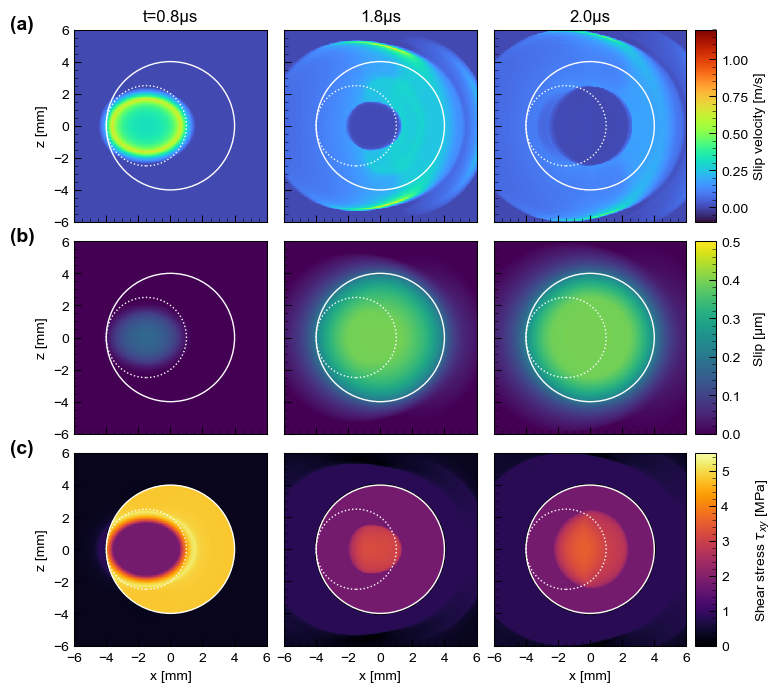

In [36]:
t_plot_list_dynrup_small = [snapshot_t_dynrup[0],snapshot_t_dynrup[2],snapshot_t_dynrup[3]]
t_plot_list_STFplot_small = [snapshot_t_STFplot[0],snapshot_t_STFplot[2],snapshot_t_STFplot[3]]

width_ratios_small = [0.196, 0.196, 0.196, 0.02 ]
fig, axs = plt.subplots(3, len(t_plot_list_dynrup_small)+1, figsize=(8.4, 8), gridspec_kw={'width_ratios': width_ratios_small})
fig.subplots_adjust(wspace=0.0, hspace=0.1)

vmax_vel = 1.2
vmin_vel = -0.1
vmax_disp = 0.5
vmin_disp = 0.0
vmax_coh = 5.5
vmin_coh = 0.0

value_factor_double = 2.0 # double the value for slip and slip velocity


# loop the plotting snaps
t_plot_true_all = []


for i, t_plot_target in enumerate(t_plot_list_dynrup_small):
    # t_plot_target = t_plot_list[i]
    t_plot_ind = np.where(df_time>=t_plot_target)[0][0]
    t_plot_true = df_time.iloc[t_plot_ind].values[0]
    t_plot_true_all.append(t_plot_true)
    
    data_vel = df_data_vel.loc[t_plot_ind, :].values
    data_disp = df_data_disp.loc[t_plot_ind, :].values
    data_coh = df_data_coh.loc[t_plot_ind, :].values
    
    V_vel = data_vel.reshape(nb_x_elements,nb_z_elements).T
    V_disp= data_disp.reshape(nb_x_elements,nb_z_elements).T
    V_coh = data_coh.reshape(nb_x_elements,nb_z_elements).T
    
    # replace 0 to small number for the logplot
    # V_vel[V_vel<=0] = 1e-12
    
    # h1 = axs[0, i].pcolormesh(X*1e3, Z*1e3, value_factor_double*V_vel, norm=colors.LogNorm(vmin=vmin_vel, vmax=vmax_vel), cmap='turbo', rasterized=True) # multiply 2 for slip velocity
    h1 = axs[0, i].pcolormesh(X*1e3, Z*1e3, value_factor_double*V_vel, norm=colors.Normalize(vmin=vmin_vel, vmax=vmax_vel), cmap='turbo', rasterized=True) # multiply 2 for slip velocity
    h2 = axs[1, i].pcolormesh(X*1e3, Z*1e3, value_factor_double*V_disp*1e6, norm=colors.Normalize(vmin=vmin_disp, vmax=vmax_disp), cmap='viridis', rasterized=True) # multiply 2 for slip velocity
    h3 = axs[2, i].pcolormesh(X*1e3, Z*1e3, V_coh/1e6, norm=colors.Normalize(vmin=vmin_coh, vmax=vmax_coh), cmap='inferno', rasterized=True)

# ax.set_xlabel("x [mm]")
# ax.set_ylabel("z [mm]")

# titlestr=f"T={tplot*1e6:4.2f}μs"
# ax.set_title(titlestr)


for ii in range(3):
    for jj in range(len(t_plot_list_dynrup_small)):

        if ii==2:
            axs[ii, jj].set_xlabel("x [mm]")
            axs[ii, jj].tick_params(axis='x', pad=5)
        else:
            axs[ii, jj].tick_params(axis='x', labelbottom=False)


        if jj==0:
            axs[ii, jj].set_ylabel("z [mm]")
        else:
            axs[ii, jj].tick_params(axis='y', labelleft=False)
        
        axs[ii, jj].set_aspect('equal', 'box')
        axs[ii, jj].set_xlim([-6, 6])
        axs[ii, jj].set_ylim([-6, 6])

        line_patch = plt.Circle((0, 0), a_patch*1e3, ec='w', fill=False)
        line_nuc = plt.Circle((nuc_x*1e3, nuc_z), a_nuc*1e3, ec='w', fill=False, ls=":")
#         line_margin = plt.Circle((0, 0), R_margin*1e3, ec='w', fill=False, ls="--")

        axs[ii, jj].add_patch(line_patch)
        axs[ii, jj].add_patch(line_nuc)
#         axs[ii, jj].add_patch(line_margin)

        axs[ii, jj].set_xticks(np.linspace(-6, 6, 7))
        axs[ii, jj].set_yticks(np.linspace(-6, 6, 7))

for kk, t_plot_true in enumerate(t_plot_list_STFplot_small):
    if kk==0:
        titlestr=f"t={t_plot_true*1e6:.1f}μs"
    else:
        titlestr=f"{t_plot_true*1e6:.1f}μs"
        
    axs[0, kk].set_title(titlestr)


# color bars
# vel
cticks = [0.001, 0.01, 0.1]
cticklabels= [str(x) for x in cticks]

cb_vel = fig.colorbar(h1, cax=axs[0, -1], orientation="vertical", shrink=1.0 )#ticks=cticks)
cb_vel.set_label("Slip velocity [m/s]")

# disp
cb_disp = fig.colorbar(h2, cax=axs[1, -1], orientation="vertical", shrink=1.0 )#ticks=cticks)
cb_disp.set_label("Slip [μm]")

# cohesion
cb_coh = fig.colorbar(h3, cax=axs[2, -1], orientation="vertical", shrink=1.0 )#ticks=cticks)
cb_coh.set_label("Shear stress $τ_{xy}$ [MPa]")

fig.align_ylabels(axs[:, -1])

# add figure labels
fig_labels = ["a", "b", "c"]
for ii in range(3):
    axs[ii, 0].text(-10, 6, f"({fig_labels[ii]})", fontsize=14, fontweight="bold", zorder=4)

# fig.tight_layout() # this reset the figure margins

plt.savefig(figdir_snapshot_master + "/master_snapshot_{}_comp{}_forslide{}.png".format(simulation_name, read_comp, filekey), dpi=300, bbox_inches="tight")
plt.savefig(figdir_snapshot_master + "/master_snapshot_{}_comp{}_forslide{}.pdf".format(simulation_name, read_comp, filekey), bbox_inches="tight")

# plt.close()
# plt.clf()

### check the patch margin

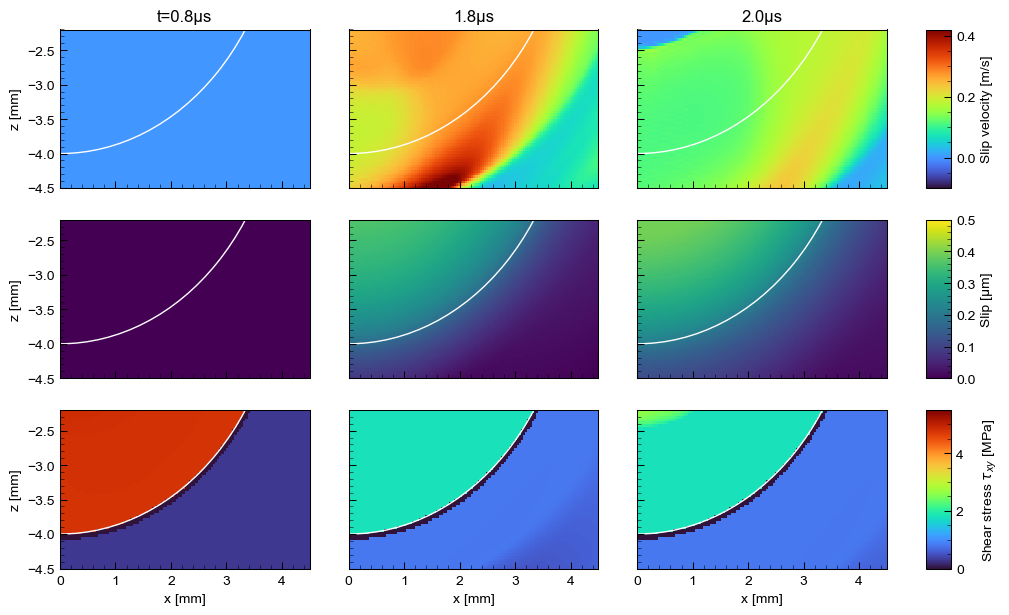

In [37]:
fig, axs = plt.subplots(3, len(t_plot_list_dynrup_small)+1, figsize=(11.5, 7), gridspec_kw={'width_ratios': width_ratios_small})
# fig.subplots_adjust(wspace=0.0, hspace=0.1)

vmax_vel = 0.42
vmin_vel = -0.1
vmax_disp = 0.5
vmin_disp = 0.0
vmax_coh = 5.5
vmin_coh = 0

value_factor_double = 2.0 # double the value for slip and slip velocity

# loop the plotting snaps
t_plot_true_all = []

for i, t_plot_target in enumerate(t_plot_list_dynrup_small):
    # t_plot_target = t_plot_list[i]
    t_plot_ind = np.where(df_time>=t_plot_target)[0][0]
    t_plot_true = df_time.iloc[t_plot_ind].values[0]
    t_plot_true_all.append(t_plot_true)
    
    data_vel = df_data_vel.loc[t_plot_ind, :].values
    data_disp = df_data_disp.loc[t_plot_ind, :].values
    data_coh = df_data_coh.loc[t_plot_ind, :].values
    
    V_vel = data_vel.reshape(nb_x_elements,nb_z_elements).T
    V_disp= data_disp.reshape(nb_x_elements,nb_z_elements).T
    V_coh = data_coh.reshape(nb_x_elements,nb_z_elements).T
    
    # replace 0 to small number for the logplot
    # V_vel[V_vel<=0] = 1e-12
    
    # h1 = axs[0, i].pcolormesh(X*1e3, Z*1e3, value_factor_double*V_vel, norm=colors.LogNorm(vmin=vmin_vel, vmax=vmax_vel), cmap='turbo', rasterized=True) # multiply 2 for slip velocity
    h1 = axs[0, i].pcolormesh(X*1e3, Z*1e3, value_factor_double*V_vel, norm=colors.Normalize(vmin=vmin_vel, vmax=vmax_vel), cmap='turbo', rasterized=True) # multiply 2 for slip velocity
    h2 = axs[1, i].pcolormesh(X*1e3, Z*1e3, value_factor_double*V_disp*1e6, norm=colors.Normalize(vmin=vmin_disp, vmax=vmax_disp), cmap='viridis', rasterized=True) # multiply 2 for slip velocity
    h3 = axs[2, i].pcolormesh(X*1e3, Z*1e3, V_coh/1e6, norm=colors.Normalize(vmin=vmin_coh, vmax=vmax_coh), cmap='turbo', rasterized=True)

# ax.set_xlabel("x [mm]")
# ax.set_ylabel("z [mm]")

# titlestr=f"T={tplot*1e6:4.2f}μs"
# ax.set_title(titlestr)


for ii in range(3):
    for jj in range(len(t_plot_list_dynrup_small)):

        if ii==2:
            axs[ii, jj].set_xlabel("x [mm]")
            axs[ii, jj].tick_params(axis='x', pad=5)
        else:
            axs[ii, jj].tick_params(axis='x', labelbottom=False)


        if jj==0:
            axs[ii, jj].set_ylabel("z [mm]")
        else:
            axs[ii, jj].tick_params(axis='y', labelleft=False)
        
#         axs[ii, jj].set_aspect('equal', 'box')
#         axs[ii, jj].set_xlim([-4.2, -3.8])
#         axs[ii, jj].set_ylim([-2, 2])
        axs[ii, jj].set_xlim([0, 4.5])
        axs[ii, jj].set_ylim([-4.5, -2.2])

        line_patch = plt.Circle((0, 0), a_patch*1e3, ec='w', fill=False)
        line_nuc = plt.Circle((nuc_x*1e3, nuc_z), a_nuc*1e3, ec='w', fill=False, ls=":")
#         line_margin = plt.Circle((0, 0), a_margin*1e3, ec='w', fill=False, ls="--")

        axs[ii, jj].add_patch(line_patch)
        axs[ii, jj].add_patch(line_nuc)
#         axs[ii, jj].add_patch(line_margin)

#         axs[ii, jj].set_xticks(np.linspace(-6, 6, 7))
#         axs[ii, jj].set_yticks(np.linspace(-6, 6, 7))

for kk, t_plot_true in enumerate(t_plot_list_STFplot_small):
    if kk==0:
        titlestr=f"t={t_plot_true*1e6:.1f}μs"
    else:
        titlestr=f"{t_plot_true*1e6:.1f}μs"
        
    axs[0, kk].set_title(titlestr)


# color bars
# vel
cticks = [0.001, 0.01, 0.1]
cticklabels= [str(x) for x in cticks]

cb_vel = fig.colorbar(h1, cax=axs[0, -1], orientation="vertical", shrink=1.0 )#ticks=cticks)
cb_vel.set_label("Slip velocity [m/s]")

# disp
cb_disp = fig.colorbar(h2, cax=axs[1, -1], orientation="vertical", shrink=1.0 )#ticks=cticks)
cb_disp.set_label("Slip [μm]")

# cohesion
cb_coh = fig.colorbar(h3, cax=axs[2, -1], orientation="vertical", shrink=1.0 )#ticks=cticks)
cb_coh.set_label("Shear stress $τ_{xy}$ [MPa]")

fig.align_ylabels(axs[:, -1])

# add figure labels
# fig_labels = ["a", "b", "c"]
# for ii in range(3):
#     axs[ii, 0].text(-10, 6, f"({fig_labels[ii]})", fontsize=14, fontweight="bold", zorder=4)

# fig.tight_layout() # this reset the figure margins

# plt.savefig(figdir_snapshot_master + "/master_snapshot_{}_comp{}.png".format(simulation_name, read_comp), dpi=300, bbox_inches="tight")
# plt.savefig(figdir_snapshot_master + "/master_snapshot_{}_comp{}.pdf".format(simulation_name, read_comp), bbox_inches="tight")

# plt.close()
# plt.clf()

# Plot opening (Only coarse mesh case)

We did not output the opening component to save the data storage but checked during the development of the model with coarse mesh.

In [38]:
read_comp = 1 #0: Mode II direction, 1: normal (Mode I), 2:Mode III direction 

# read velocity
read_parameter = f"top_velo_{read_comp}" # select the parameter to read
if IfBinaryOutput:
    D = np.fromfile(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), dtype="float32")
    df_data_vel = pd.DataFrame(data=D.reshape((NT, -1)))
else:
    df_data_vel = pd.read_csv(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), header=None, sep=' ', engine="c")
    
# read displacement
read_parameter = f"top_disp_{read_comp}" # select the parameter to read
if IfBinaryOutput:
    D = np.fromfile(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), dtype="float32")
    df_data_disp = pd.DataFrame(data=D.reshape((NT, -1)))
else:
    df_data_disp = pd.read_csv(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), header=None, sep=' ', engine="c")

# read cohesion (shear traction)
read_parameter = f"cohesion_{read_comp}" # select the parameter to read
if IfBinaryOutput:
    D = np.fromfile(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), dtype="float32")
    df_data_coh = pd.DataFrame(data=D.reshape((NT, -1)))
else:
    df_data_coh = pd.read_csv(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), header=None, sep=' ', engine="c")
  

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Okuboetal2025_masterHDD/RuptureSimulation/main_casestudy/build_hpcv62_mastercase_v3/simulations_main_casestudy_hpc_master/fb03-087__0129_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4100-DataFiles/top_velo_1.out'

## Plot snapshots

In [ ]:
colorbargridwidth = 0.02
width_ratios = np.hstack([np.ones(len(snapshot_t_dynrup))*(1-colorbargridwidth)/len(snapshot_t_dynrup), colorbargridwidth])

In [ ]:
2*df_data_vel.max().max(), 2*df_data_disp.max().max()*1e6, df_data_coh.max().max()/1e6

In [ ]:
fig, axs = plt.subplots(3, len(snapshot_t_dynrup)+1, figsize=(11.5, 7), gridspec_kw={'width_ratios': width_ratios})
fig.subplots_adjust(wspace=0.0, hspace=0.1)

vmax_vel = 0.42
vmin_vel = 0
vmax_disp = 0.1
vmin_disp = -0.1
vmax_coh = 7
vmin_coh = 0.0

value_factor_double = 2.0 # double the value for slip and slip velocity


# loop the plotting snaps
t_plot_true_all = []

for i, t_plot_target in enumerate(snapshot_t_dynrup):
    # t_plot_target = t_plot_list[i]
    t_plot_ind = np.where(df_time>=t_plot_target)[0][0]
    t_plot_true = df_time.iloc[t_plot_ind].values[0]
    t_plot_true_all.append(t_plot_true)
    
    data_vel = df_data_vel.loc[t_plot_ind, :].values
    data_disp = df_data_disp.loc[t_plot_ind, :].values
    data_coh = df_data_coh.loc[t_plot_ind, :].values
    
    V_vel = data_vel.reshape(nb_x_elements,nb_z_elements).T
    V_disp= data_disp.reshape(nb_x_elements,nb_z_elements).T
    V_coh = data_coh.reshape(nb_x_elements,nb_z_elements).T
    
    # replace 0 to small number for the logplot
#     V_vel[V_vel<=0] = 1e-12
    
    # h1 = axs[0, i].pcolormesh(X*1e3, Z*1e3, value_factor_double*V_vel, norm=colors.LogNorm(vmin=vmin_vel, vmax=vmax_vel), cmap='turbo', rasterized=True) # multiply 2 for slip velocity
    h1 = axs[0, i].pcolormesh(X*1e3, Z*1e3, 1.0*V_vel, norm=colors.Normalize(vmin=vmin_vel, vmax=vmax_vel), cmap='turbo', rasterized=True) # 
    h2 = axs[1, i].pcolormesh(X*1e3, Z*1e3, 1.0*V_disp*1e6, norm=colors.Normalize(vmin=vmin_disp, vmax=vmax_disp), cmap='viridis', rasterized=True) # 
    h3 = axs[2, i].pcolormesh(X*1e3, Z*1e3, -V_coh/1e6, norm=colors.Normalize(vmin=vmin_coh, vmax=vmax_coh), cmap='inferno', rasterized=True) # normal stress

# ax.set_xlabel("x [mm]")
# ax.set_ylabel("z [mm]")

# titlestr=f"T={tplot*1e6:4.2f}μs"
# ax.set_title(titlestr)


for ii in range(3):
    for jj in range(len(snapshot_t_dynrup)):

        if ii==2:
            axs[ii, jj].set_xlabel("x [mm]")
            axs[ii, jj].tick_params(axis='x', pad=5)
        else:
            axs[ii, jj].tick_params(axis='x', labelbottom=False)


        if jj==0:
            axs[ii, jj].set_ylabel("z [mm]")
        else:
            axs[ii, jj].tick_params(axis='y', labelleft=False)
        
        axs[ii, jj].set_aspect('equal', 'box')
        axs[ii, jj].set_xlim([-6, 6])
        axs[ii, jj].set_ylim([-6, 6])

        line_patch = plt.Circle((0, 0), a_patch*1e3, ec='w', fill=False)
        line_nuc = plt.Circle((nuc_x*1e3, nuc_z), a_nuc*1e3, ec='w', fill=False, ls=":")
#         line_margin = plt.Circle((0, 0), R_margin*1e3, ec='w', fill=False, ls="--")

        axs[ii, jj].add_patch(line_patch)
        axs[ii, jj].add_patch(line_nuc)
#         axs[ii, jj].add_patch(line_margin)

        axs[ii, jj].set_xticks(np.linspace(-6, 6, 7))
        axs[ii, jj].set_yticks(np.linspace(-6, 6, 7))

for kk, t_plot_true in enumerate(snapshot_t_STFplot):
    if kk==0:
        titlestr=f"t={t_plot_true*1e6:.1f}μs"
    else:
        titlestr=f"{t_plot_true*1e6:.1f}μs"
        
    axs[0, kk].set_title(titlestr)


# color bars
# vel
cticks = [0.001, 0.01, 0.1]
cticklabels= [str(x) for x in cticks]

cb_vel = fig.colorbar(h1, cax=axs[0, -1], orientation="vertical", shrink=1.0 )#ticks=cticks)
cb_vel.set_label("Normal velocity\n of top half [m/s]")

# disp
cb_disp = fig.colorbar(h2, cax=axs[1, -1], orientation="vertical", shrink=1.0 )#ticks=cticks)
cb_disp.set_label("Normal displacement\n of top half [μm]")

# cohesion
cb_coh = fig.colorbar(h3, cax=axs[2, -1], orientation="vertical", shrink=1.0 )#ticks=cticks)
cb_coh.set_label("Normal stress [MPa]")

fig.align_ylabels(axs[:, -1])

# add figure labels
fig_labels = ["a", "b", "c"]
for ii in range(3):
    axs[ii, 0].text(-10, 6, f"({fig_labels[ii]})", fontsize=14, fontweight="bold", zorder=4)

# fig.tight_layout() # this reset the figure margins

plt.savefig(figdir_snapshot_master + "/master_snapshot_{}_comp{}{}.png".format(simulation_name, read_comp, filekey), dpi=300, bbox_inches="tight")
plt.savefig(figdir_snapshot_master + "/master_snapshot_{}_comp{}{}.pdf".format(simulation_name, read_comp, filekey), bbox_inches="tight")

# plt.close()
# plt.clf()